In [1]:
import torch
import transformers
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from random import shuffle

### Models

#### Baseline

In [ ]:
from src.baseline.model import Model
from src.baseline.search import GreedySearch

def get_baseline():
    tokenizer = transformers.AutoTokenizer.from_pretrained("distilgpt2", use_fast=False, model_max_length=512, add_bos_token=True)
    tokenizer.add_special_tokens({
        "pad_token" : "<pad>"
    })
    model_d = torch.load("/tmp/xsaman02/models/baseline/baseline.evaluated.pt", map_location="cpu")
    configuration = model_d.get("configuration")
    loss_fce = torch.nn.CrossEntropyLoss(ignore_index=-1)
    
    model = Model(len(tokenizer), configuration.get("d_model"), loss_fce, tokenizer.pad_token_id, tokenizer.bos_token_id, configuration)
    model.load_state_dict(model_d.get("model_dict"))
    
    return tokenizer, model, model_d

tokenizer, model, model_d = get_baseline()

#### T5

In [2]:
def get_t5():
    tokenizer = transformers.AutoTokenizer.from_pretrained("t5-small", use_fast=False, model_max_length=512, add_bos_token=True)
    tokenizer.add_tokens(["{", "}", "<", ">", ";", "[", "]", "&", "*"])
    config = transformers.AutoConfig.from_pretrained("t5-small")
    model = transformers.AutoModelForSeq2SeqLM.from_config(config)
    model.resize_token_embeddings(len(tokenizer))
    model = model.eval()

    model_d = torch.load("/tmp/xsaman02/models/t5-small/t5-small_pretrained.best.pt", map_location="cpu")
    model.load_state_dict(model_d.get("model_dict"))
    
    return tokenizer, model, model_d

tokenizer, model, model_d = get_t5()

<All keys matched successfully>

In [ ]:
def get_gpt2():
    tokenizer = transformers.AutoTokenizer.from_pretrained("distilgpt2", use_fast=False, model_max_length=512, add_bos_token=True)
    config = transformers.AutoConfig.from_pretrained("distilgpt2")
    tokenizer.padding_side = "left"
    tokenizer.add_special_tokens({
        "pad_token" : "<pad>"
    })
    model = transformers.AutoModelForCausalLM.from_config(config)
    model.resize_token_embeddings(len(tokenizer))
    model = model.eval()

    model_d = torch.load("/home/xsaman02/Project/models/gpt2/gpt2.evaluated.pt", map_location="cpu")
    model.load_state_dict(model_d.get("model_dict"))
    
    return tokenizer, model, model_d

tokenizer, model, model_d = get_bart()

#### BART

In [ ]:
def get_bart():
    tokenizer = transformers.AutoTokenizer.from_pretrained("facebook/bart-large", use_fast=False, model_max_length=512, add_bos_token=True)
    config = transformers.AutoConfig.from_pretrained("facebook/bart-large")
    model = transformers.AutoModelForSeq2SeqLM.from_config(config)
    model.resize_token_embeddings(len(tokenizer))
    model = model.eval()

    model_d = torch.load("/home/xsaman02/Project/models/bart/bart.evaluated.pt", map_location="cpu")
    model.load_state_dict(model_d.get("model_dict"))
    
    return tokenizer, model, model_d

tokenizer, model, model_d = get_bart()

#### CodeGen

In [ ]:
def get_codegen():
    tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-multi", use_fast=False)
    tokenizer.padding_side = "left"
    tokenizer.model_max_length=MAX_SEQUENCE_SIZE
    tokenizer.add_special_tokens({
        "pad_token" : "</s>"
    })
    
    config = transformers.AutoConfig.from_pretrained("Salesforce/codegen-350M-multi")
    model = transformers.AutoModelForCausalLM.from_config(config)
    model.resize_token_embeddings(len(tokenizer))
    model = model.eval()

    model_d = torch.load("/home/xsaman02/Project/models/codeGen/codegen.evaluated.pt", map_location="cpu")
    model.load_state_dict(model_d.get("model_dict"))
    
    return tokenizer, model, model_d

tokenizer, model, model_d = get_codegen()

In [74]:
prompt = """
// Kernel for dividing by two
__device__ float divideByTwo(float v)
""".strip()

target = """
{
    return v / 2;
}
""".strip()

In [75]:
x = tokenizer(prompt, max_length=100, padding=True, truncation=True, return_tensors="pt")
y = tokenizer(target, max_length=100, padding=True, truncation=True, return_tensors="pt")

input_tokens = [token.replace("▁", "") for token in tokenizer.convert_ids_to_tokens(x["input_ids"][0], skip_special_tokens=True)]
target_tokens = [token.replace("▁", "") for token in tokenizer.convert_ids_to_tokens(y["input_ids"][0], skip_special_tokens=True)]

output = model(**x, labels=y["input_ids"], output_attentions=True)
logits = output.logits
pred = torch.argmax(logits, dim=-1)
print(f"Loss: {output.loss:.3f}")
print(tokenizer.batch_decode(pred, skip_special_tokens=True)[0].replace(";", ";\n").replace("{", "{\n").replace("}", "}\n"))

Loss: 0.996
{
 return v */ 2;
 }



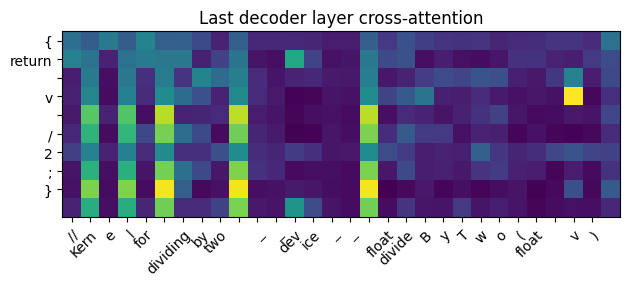

In [63]:
last_cross_attention = output.cross_attentions[-1]
attention = torch.sum(last_cross_attention, dim=1).squeeze().detach().numpy()
# plt.imshow(attention)
# plt.title()
# plt.show()


fig, ax = plt.subplots()
plt.imshow(attention)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(input_tokens)), labels=input_tokens)
ax.set_yticks(np.arange(len(target_tokens)), labels=target_tokens)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# for i in range(len(target_tokens)):
#     for j in range(len(input_tokens)):
#         text = ax.text(j, i, attention[i, j],
#                        ha="center", va="center", color="w")

ax.set_title("Last decoder layer cross-attention")
fig.tight_layout()
plt.show()

### Get highest loss kernels

In [31]:
model = model.eval()
losses = []
sample = 5000
l = list(zip(model_d.get("source_sentences"), model_d.get("target_sentences")))
pred_sentences = []
sample_size_loss_list = []
shuffle(l)
for i, (src, tgr) in tqdm(enumerate(l[:sample])):
    x = tokenizer(src, max_length=300, padding=True, truncation=True, return_tensors="pt")
    y = tokenizer(tgr, max_length=300, padding=True, truncation=True, return_tensors="pt")
    
    output = model(**x, labels=y["input_ids"])
    pred = torch.max(output.logits, dim=-1)[1][0]
    
    losses.append(output.loss.item())
    pred_sentences.append(tokenizer.decode(pred, skip_special_tokens=True))
    

0it [00:00, ?it/s]

In [12]:
losses = np.array(losses)
sorted_ids = np.argsort(losses)[::-1]
losses[sorted_ids[:10]]

array([17.17609215, 17.0750618 , 16.17748642, 10.75864697, 10.0801754 ,
        9.8966589 ,  9.62562752,  9.57193089,  9.49740887,  9.39343929])

In [8]:
source_l = model_d.get("source_sentences")
target_l = model_d.get("target_sentences")
pred_l = model_d.get("pred_sentences")

for ls_idx in sorted_ids[:10]:
    loss = losses[ls_idx]
    src = source_l[ls_idx]
    tgr = target_l[ls_idx]
    origin_prd = pred_l[ls_idx]
    prd = pred_sentences[ls_idx]
    
    print(f"Loss: {loss:.3f}")
    print("SOURCE:")
    print(src)
    
    print("\nTARGET:")
    print(tgr)
    
    print("\nPREDICT:")
    print(prd.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n"))
    print("#--------------------------#\n")

Loss: 22.373
SOURCE:
supplement code:// First derivative of F, also defined on intervals
template<class T>
__device__ interval_gpu fd(interval_gpu const &x, int thread_id)

TARGET:
{
    typedef interval_gpu<T> I;
    T alpha = -T(thread_id) / T(THREADS);
    return I(2) * x + I(alpha - 2);
}

PREDICT:
{
 
#--------------------------#

Loss: 17.075
SOURCE:
supplement code:// brief Shift-right then add.  Returns (\p x >> \p shift) + \p addend.
__device__ __forceinline__ unsigned int SHR_ADD(
    unsigned int x,
    unsigned int shift,
    unsigned int addend)

TARGET:
{
    unsigned int ret;
#if CUB_PTX_ARCH >= 200
    asm ("vshr.u32.u32.u32.clamp.add %0, %1, %2, %3;" :
        "=r"(ret) : "r"(x), "r"(shift), "r"(addend));
#else
    ret = (x >> shift) + addend;
#endif
    return ret;
}

PREDICT:
{
 in
#--------------------------#

Loss: 15.614
SOURCE:
supplement code:// Compute device memory needed for tile status
__host__ __device__ __forceinline__
static cudaError_t AllocationSize(
  

### Grouping samples by input & output sizes

In [32]:
loss_list = losses
input_len_list = []
target_len_list = []

for (src, tgr), prd in zip(l[:sample], pred_sentences):
    input_len_list.append(len(tokenizer.encode(src)))
    target_len_list.append(len(tokenizer.encode(tgr)))
    

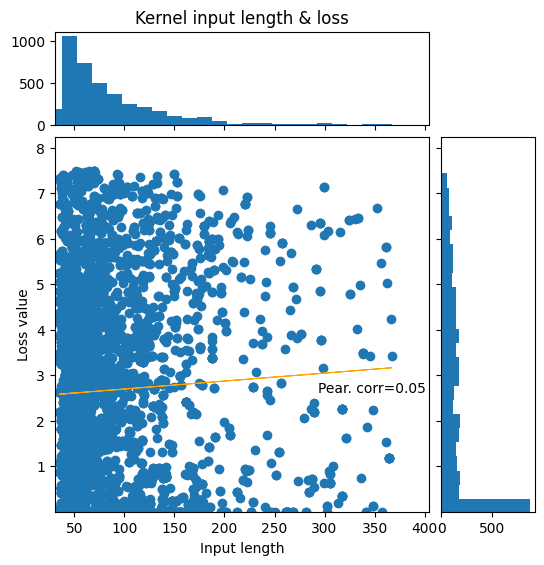

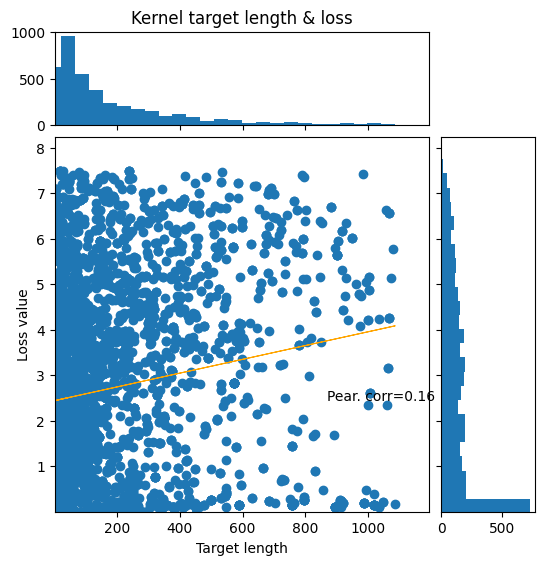

In [33]:
from sklearn.linear_model import LinearRegression 
from scipy.stats import pearsonr

def scatter_hist(x, y, ax, ax_histx, ax_histy, title):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    
    regressor = LinearRegression() 
    regressor.fit(np.array(x).reshape((len(x),1)), y)
    p_y = regressor.predict(np.array(x).reshape((len(x),1)))
    corr, _ = pearsonr(x, y)
    ax.plot(x, p_y, linewidth=0.75, color="orange")
    ax.text(max(x)*0.8, p_y[-1], f"Pear. corr={corr:.2f}")

    # now determine nice limits by hand:
    binwidth = 0.25
    
    xmax = np.max(np.abs(x))
    xlim = (int(xmax/binwidth) + 1) * binwidth
    xbins = np.linspace(-xlim, xlim + binwidth, 50)
    
    ymax = np.max(np.abs(y))
    ylim = (int(ymax/binwidth) + 1) * binwidth
    ybins = np.linspace(-ylim, ylim + binwidth, 50)

    ax_histx.hist(x, bins=xbins)
    ax_histx.set_title(title)
    ax_histy.hist(y, bins=ybins, orientation='horizontal')

def plot_scatter_with_dist(x, y, title, xlabel, ylabel):
    x = np.array(x)
    y = np.array(y)
    
    # Start with a square Figure.
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    
    min_x = np.quantile(x, 0.05)
    max_x = np.quantile(x, 0.95)
    min_y = np.quantile(y, 0.05)
    max_y = np.quantile(y, 0.95)
    
    # x_mask = np.where(x > min_x and x < max_x)
    # x = x[x_mask]
    x_mask = ((x > min_x) & (x < max_x))
    x = x[x_mask]
    y = y[x_mask]
    y_mask = ((y > min_y) & (y < max_y))
    x = x[y_mask]
    y = y[y_mask]
    
    # Draw the scatter plot and marginals.
    scatter_hist(x, y, ax, ax_histx, ax_histy, title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(min_x*0.9, max_x*1.1)
    ax.set_ylim(min_y*0.9, max_y*1.1)
    plt.show()
    
    
target_len_list = np.array(target_len_list)
input_len_list = np.array(input_len_list)
loss_list = np.array(loss_list)

plot_scatter_with_dist(input_len_list, loss_list, "Kernel input length & loss", "Input length", "Loss value")
plot_scatter_with_dist(target_len_list, loss_list, "Kernel target length & loss", "Target length", "Loss value")


### Analyze use of indices

In [79]:
global_c = 0
global_f = 0
other_c = 0
other_f = 0

for src, prd in tqdm(list(zip(model_d.get("source_sentences"), model_d.get("pred_sentences")))):
    one_line_src = src.replace("\n", " ")
    is_global = one_line_src.find("__global__") != -1
    
    prd_lines = prd.splitlines()
    found = False
    for line in prd_lines:
        if line.find("threadIdx.") != -1 and line.find("blockIdx.") != -1 and line.find("blockDim.") != -1:
            if is_global:
                global_c += 1
            else:
                other_f += 1
            found = True
            break
        
    if not found:
        if is_global:
            global_f += 1
        else:
            other_c += 1

print(f"global_c: {global_c} ({global_c/(global_c+global_f):.2%})")
print(f"global_f: {global_f} ({global_f/(global_c+global_f):.2%})")
print(f"others_c: {other_c} ({other_c/(other_c+other_f):.2%})")
print(f"others_f: {other_f} ({other_f/(other_c+other_f):.2%})")

total = global_c + global_f + other_c + other_f
correct = global_c + other_c
incorrect = global_f + other_f
print(f"Correct: {correct} ({correct/total:.2%})")
print(f"Incorrect: {incorrect}, ({incorrect/total:.2%})")

    

  0%|          | 0/36441 [00:00<?, ?it/s]

global_c: 8760 (72.49%)
global_f: 3324 (27.51%)
others_c: 23529 (96.60%)
others_f: 828 (3.40%)
Correct: 32289 (88.61%)
Incorrect: 4152, (11.39%)


### Use of local memory analyses

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
t_p = 0
t_n = 0
f_p = 0
f_n = 0

t = []
p = []

for tgr, prd in tqdm(list(zip(model_d.get("target_sentences"), model_d.get("pred_sentences")))):
    tgr_l_m_use = tgr.find("__shared__") != -1 or tgr.find("__constant__") != -1
    prd_l_m_use = prd.find("__shared__") != -1 or prd.find("__constant__") != -1
    
    if tgr_l_m_use:
        if prd_l_m_use:
            t_p += 1
        else:
            f_n += 1
    else:
        if prd_l_m_use:
            f_p += 1
        else:
            t_n += 1
            
    t.append(tgr_l_m_use)
    p.append(prd_l_m_use)
    
total = t_p + t_n + f_p + f_n
print(f"True positive: {t_p}\t({t_p/total:.2%})")
print(f"True negative: {t_n}\t({t_n/total:.2%})")
print(f"False positive: {f_p}\t({f_p/total:.2%})")
print(f"False negative: {f_n}\t({f_n/total:.2%})")

precision = precision_score(t, p)
recall = recall_score(t, p)
f1 = f1_score(t, p)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {f1:.3f}")


  0%|          | 0/36441 [00:00<?, ?it/s]

True positive: 1425	(3.91%)
True negative: 31961	(87.71%)
False positive: 1193	(3.27%)
False negative: 1862	(5.11%)
Precision: 0.544
Recall: 0.434
F1: 0.483
